# Prey notebook

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import neat
import matplotlib.pyplot as plt

import pickle
import multimodal_mazes
from tqdm import tqdm

## Rule-based Agents

### Hyperparameters

In [2]:
# Hyperparameters 
width=21
height=21
n_prey = 1
n_steps = 100
n_trials = 100
pk = 40 # the width of the prey's Gaussian signal (in rc)
visible_steps = n_steps
scenario =  "Constant"
motion = "Linear"
multisensory = "Unisensory"

if scenario == "Static":
    pc = 0.0
    pm = 0
    pe = 1
    motion = None
elif scenario == "Constant":
    pc = 0.0
    pm = 1
    pe = 0.998
    noise = 0.002
    case = "2"
elif scenario == "Random":
    pc = 0.0
    pm = 1
    pe = 0.2
    motion = "Levy"
    case = "1"
elif scenario == "Two Prey":
    pc = 0.0
    pm = 0
    pe = 0.998
    noise = 0.002
    multisensory = "Balanced"
    case = "4"
    n_prey = 2

### Plotting

In [ ]:
visible_steps = n_steps
pm = 0

agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy='Nonlinear fusion')
# time, path, prey_state, preys, env_log = multimodal_mazes.linear_prey_trial(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk,n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe, log_env=True)
trial = multimodal_mazes.PredatorTrial(width=width, height=height, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk,n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=pm, pe=pe, log_env=True)
time, path, prey_state, preys, env_log = trial.run_trial()
print(prey_state)
print(len(path))

In [ ]:
import matplotlib.animation as animation
prey_markers = ['P', 'X']

# Colormaps 
from matplotlib import colors
import matplotlib.cm as cm

cmap_wall = cm.binary
cmap_wall.set_under('k', alpha=0)

cmap_ch0 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:ultramarine"]
)

cmap_ch1 = colors.LinearSegmentedColormap.from_list(
    "", ["white", "xkcd:magenta"]
)

fig, ax = plt.subplots()

# Environment 
plt.imshow(1 - env_log[0][:, :, -1], clim=[0.1,1.0], cmap=cmap_wall, alpha=0.25, zorder=1)
plt.imshow((cmap_ch0(env_log[1][:,:,0]) + cmap_ch1(env_log[1][:,:,1]))/2, interpolation='gaussian', zorder=0) 

# Adjust axes 
plt.xlim([(pk//2) - 1, width + pk//2])
plt.ylim([height + pk//2, (pk//2) - 1]) 
plt.axis("off")

# Initial data 
agnt_animation = ax.scatter([], [], s=120, color='k', zorder=3)
preys_animation = [[] for _ in preys]
for a, prey in enumerate(preys): 
    if scenario == "Static":
     preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[prey.cues], zorder=2)
    elif scenario != "Static": 
        preys_animation[a] = ax.scatter([], [], s=60, color='k', alpha=0.5, marker=prey_markers[0], zorder=2)

# Animate 
def update_animation(t):
    plt.imshow((cmap_ch0(env_log[t][:,:,0]) + cmap_ch1(env_log[t][:,:,1]))/2, interpolation='gaussian', zorder=0) 

    agnt_animation.set_offsets([path[t, 1], path[t, 0]])

    for a, prey in enumerate(preys): 
        try:
            preys_animation[a].set_offsets([prey.path[t][1], prey.path[t][0]])
        except:
            preys_animation[a].set(alpha=0)

#anim = animation.FuncAnimation(fig, update_animation, frames=range(0, len(path)), blit=False)
anim = animation.FuncAnimation(fig, update_animation, frames=range(0, 20), blit=False)
anim.save("Test.gif", dpi=300)


In [ ]:
# 2 channel colormap
input_values = np.linspace(0,1,num=11)
a,b = np.meshgrid(input_values, input_values)

plt.imshow((cmap_ch0(a) + cmap_ch1(b))/2, zorder=0, origin='lower')
plt.xticks(ticks=range(len(input_values)), labels=np.round(input_values,1), rotation='vertical')
plt.yticks(ticks=range(len(input_values)), labels=np.round(input_values,1))
plt.xlabel('Ch0 input')
plt.ylabel('Ch1 input')

### Percentage capture vs speed per case

In [ ]:
# % Capture vs speed

noise = 0.002
pe = 0.998
n_trials = 10
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(speeds), len(policies)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{motion}, {multisensory} - Percentage Captured vs Speed")


# Test agents
for case in tqdm(range(len(cases))):
    for a, speed in tqdm(enumerate(speeds)):
        for b, policy in enumerate(policies): 
            if policy in multimodal_mazes.AgentRuleBased.policies:
                agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
            elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
                agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
                agnt.alpha = 0.6
                
            elif policy == "Levy":
                agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

            evaluator = multimodal_mazes.LinearPreyFitnessEvaluator(height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            _, _, _, _, captured, _ = evaluator.evaluate(n_trials=n_trials)
            results[a, b] = captured
    

    for b, policy in enumerate(policies): 
        axs[case].plot(speeds, results[:,b], color=colors[b])    
        axs[case].set_title(f"Case {case+1}")

axs[0].set(xlabel='Speed', ylabel='Percentage Captured')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));
fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5), labels=policies)

In [ ]:
# % Capture vs speed
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
repeats = [i for i in range(4)]
n_trials = 100
pe = 1
noise = 0
policy = multimodal_mazes.AgentRuleBased.policies[7]
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
# policy = multimodal_mazes.AgentRuleBasedMemory.policies[0]
# agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(speeds), len(repeats)))
trials = {n: {case: {pm: [] for pm in range(len(speeds))} for case in range(len(cases))} for n in range(len(repeats))}

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} {policy} Percentage Captured vs Speed")

for case in tqdm(range(len(cases))):
    capture_results = np.zeros((2, len(speeds)))
    for a, speed in tqdm(enumerate(speeds)):
        
        for b in repeats:
            captured = 0
            evaluator = multimodal_mazes.LinearPreyFitnessEvaluator(height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            _, _, paths, _, captured, _ = evaluator.evaluate(n_trials=n_trials)
            results[a, b] = captured
            trials[b][case][a] = paths
        capture_results[0, a] = np.mean(results[a,:])
        capture_results[1, a] = np.std(results[a,:])
    
    for b in repeats:
        axs[case].plot(speeds, results[:,b], color = colors[case], alpha = 0.2)
        axs[case].set_title(f"Case {case+1}")
        axs[case].plot(speeds, capture_results[0, :], color=colors[case])
        axs[3].plot(speeds, capture_results[0, :], color=colors[case])
        axs[case].errorbar(speeds, capture_results[0, :], yerr=capture_results[1, :], color=colors[case])
        axs[3].errorbar(speeds, capture_results[0, :], yerr=capture_results[1, :], color=colors[case])

axs[0].set(xlabel='Speed', ylabel='Percentage Captured')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

In [ ]:
colors = {0: [plt.get_cmap('Blues')(i) for i in np.arange(0, 1.1, 0.1)], 
          1: [plt.get_cmap('Oranges')(i) for i in np.arange(0, 1.1, 0.1)], 
          2: [plt.get_cmap('Reds')(i) for i in np.arange(0, 1.1, 0.1)]}

coords = {case: {'y': {pm: [] for pm in range(len(speeds))}, 'x': {pm: [] for pm in range(len(speeds))}} for case in range(len(cases))}
mean_coords = {case: {'mean_x': {pm: [] for pm in range(len(speeds))}, 'unique_y': {pm: [] for pm in range(len(speeds))}} for case in range(len(cases))}
    
for case in range(len(cases)):
    for repeat in range(len(repeats)):          
        for a in range(len(speeds)):
            x_coords, y_coords = [], []
            
            for trial in trials[repeat][case][a]:
                print(trial)
                for location in trial:
                    y = height + pk - location[0]
                    x = width + pk - location[1] if trial[0][1] < trial[-1][1] else location[1]
                    y_coords.append(y)
                    x_coords.append(x)
    
            coords[case]['y'][a] = y_coords
            coords[case]['x'][a] = x_coords

            x_values = np.array(x_coords)
            y_values = np.array(y_coords)
            unique_ys = np.unique(y_values)

            mean_xs = np.array([x_values[y_values == y].mean() for y in unique_ys])
            mean_coords[case]['mean_x'][a] = mean_xs
            mean_coords[case]['unique_y'][a] = unique_ys


In [ ]:
for a in range(len(speeds)):
    # plt.plot(coords[0]['x'][a], coords[0]['y'][a], color=colors[0][a], alpha=0.01)
    plt.plot(mean_coords[0]['mean_x'][a], mean_coords[0]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[0][a])
    
plt.title('Case 1')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(speeds)):
    plt.plot(coords[1]['x'][a], coords[1]['y'][a], color=colors[1][a], alpha=0.01)
    plt.plot(mean_coords[1]['mean_x'][a], mean_coords[1]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[1][a])
    
plt.title('Case 2')
plt.axis("off")        
plt.legend()

In [ ]:
for a in range(len(speeds)):
    plt.plot(coords[2]['x'][a], coords[2]['y'][a], color=colors[2][a], alpha=0.01)
    plt.plot(mean_coords[2]['mean_x'][a], mean_coords[2]['unique_y'][a], label=np.round(speeds[a], 1), color=colors[2][a])
    
    
plt.title('Case 3')
plt.axis("off")        
plt.legend()

In [ ]:
# % Approached vs speed
cases = ["1", "2", "3"]
speeds = np.linspace(start=0.0, stop=1.0, num=10)
repeats = [i for i in range(4)]
n_trials = 100
pe = 0.998
noise = 0.002
policy = multimodal_mazes.AgentRuleBased.policies[7]
agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
# policy = multimodal_mazes.AgentRuleBasedMemory.policies[0]
# agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(speeds), len(repeats)))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])
fig.suptitle(f"{multisensory} {policy} Percentage Approached vs Speed")

for case in tqdm(range(len(cases))):
    approach_results = np.zeros((2, len(speeds)))
    for a, speed in tqdm(enumerate(speeds)):
        
        for b in repeats:
            approached = 0
            evaluator = multimodal_mazes.LinearPreyFitnessEvaluator(height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[case], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speeds[a], pe=pe)
            _, _, _, _, _, approached = evaluator.evaluate(n_trials=n_trials)
            results[a, b] = approached
        approach_results[0, a] = np.mean(results[a,:])
        approach_results[1, a] = np.std(results[a,:])
    
    for b in repeats:
        axs[case].plot(speeds, results[:,b], color = colors[case], alpha = 0.2)
        axs[case].set_title(f"Case {case+1}")
        axs[case].plot(speeds, approach_results[0, :], color=colors[case])
        axs[3].plot(speeds, approach_results[0, :], color=colors[case])
        axs[case].errorbar(speeds, approach_results[0, :], yerr=approach_results[1, :], color=colors[case])
        axs[3].errorbar(speeds, approach_results[0, :], yerr=approach_results[1, :], color=colors[case])

axs[0].set(xlabel='Speed', ylabel='Percentage Approached')
axs[0].set_xticks(np.arange(0.0, 1.1, 0.2));

### Disappearing percentage capture vs visible time

Text(0.5, 0.98, 'Unisensory Recurrent outputs Percentage Approached vs Time to Disappear')

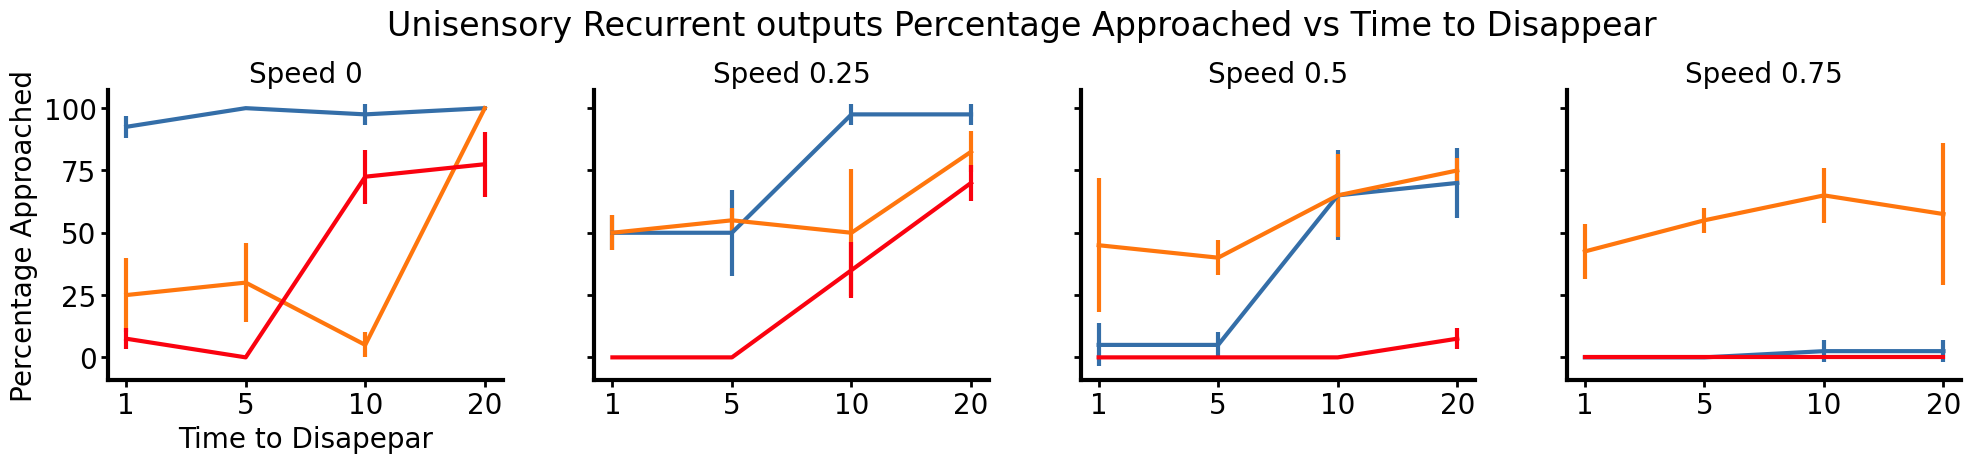

In [17]:
# % Approached vs visible time steps poster scaling

speeds = [0, 0.25, 0.5, 0.75]
repeats = [i for i in range(4)]
cases = ["1", "2", "3"]
visible_periods = [3, 2, 1, 0]
visible_periods_str = ['1', '5', '10', '20']
n_trials = 10
# policy = multimodal_mazes.AgentRuleBased.policies[7]
# agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
policy = multimodal_mazes.AgentRuleBasedMemory.policies[0]
agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
results = np.zeros((len(visible_periods), len(repeats)))

fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)
fig.tight_layout(rect=[0,0.1, 1, 0.9])

# Test agents
case_results = np.zeros((len(speeds), len(cases), len(visible_periods)))
for d, speed in enumerate(speeds):
    for a, case in enumerate(cases):
        approach_results = np.zeros((2, len(visible_periods)))

        for b, period in enumerate(visible_periods):
            actual_period = int(visible_periods_str[period])
            
            for c in repeats:
                evaluator = multimodal_mazes.LinearPreyFitnessEvaluator(height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, motion=motion, visible_steps=actual_period, multisensory=multisensory, pc=pc, pm=speed, pe=pe)
                _, _, _, _, _, approached = evaluator.evaluate(n_trials=n_trials)
            
                results[b, c] = approached
                
            approach_results[0, b] = np.mean(results[b,:])
            approach_results[1, b] = np.std(results[b,:])
            
        case_results[d, a] = approach_results[0]

        for c in repeats:
            # axs[d].plot(visible_periods, results[:,c], color=colors[a], alpha=0.2)    
            axs[d].set_title(f"Speed {speed}")  

        axs[d].errorbar(visible_periods, approach_results[0, :], yerr=approach_results[1, :], color=colors[a])

averaged_case_results = np.mean(case_results, axis=0)
        
axs[0].set(xlabel='Time to Disapepar', ylabel='Percentage Approached')
axs[0].set_xticks(range(4), visible_periods_str);
fig.suptitle(f"{multisensory} {policy} Percentage Approached vs Time to Disappear")  

Text(0, 0.5, 'Percentage Approached')

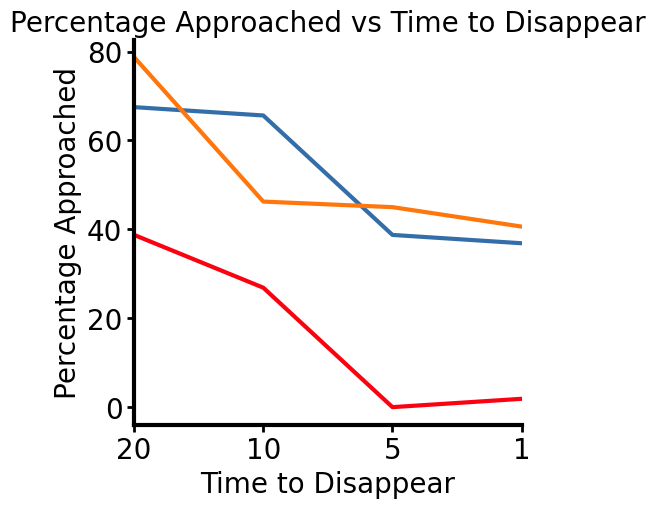

In [19]:
for a, case in enumerate(averaged_case_results):
    plt.plot(visible_periods, case, color=colors[a])

plt.xlim(3, 0)
plt.xticks(range(4), visible_periods_str);
plt.title('Percentage Approached vs Time to Disappear')
plt.xlabel('Time to Disappear')
plt.ylabel('Percentage Approached')

### Two prey capture probabilty

In [ ]:
# Two prey capture probability vs noise
n_trials = 100
pm = 0
noises = np.linspace(start=0.0, stop=1.0, num=10)
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(noises), len(policies)))

for a, noise in enumerate(noises):
    for b, policy in enumerate(policies): 
        if policy in multimodal_mazes.AgentRuleBased.policies:
            agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
        elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
            agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
            agnt.alpha = 0.6
        elif policy == "Levy":
            agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

        _, _, _, preys, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, visible_steps=visible_steps, multisensory=multisensory, motion=motion, pc=pc, pm=pm, pe=pe)
        
        ms_captured = 0

        for prey in preys:
            if prey[0].state == 0:
                ms_captured += 1
        ms_captured = (ms_captured / n_trials)
        results[a, b] = ms_captured

plt.figure(figsize=(10, 10))
for b, policy in enumerate(policies): 
    plt.plot(noises, results[:,b], color=colors[b], label=policy)
plt.ylabel('Probability of Multisensory Prey Caught First')
plt.xlabel('Noise')
plt.yticks(np.arange(0.0, 1.1, 0.1));

In [ ]:
# Two prey capture probability
n_trials = 100
policies = multimodal_mazes.AgentRuleBased.policies + multimodal_mazes.AgentRuleBasedMemory.policies + ["Levy"]
colors = multimodal_mazes.AgentRuleBased.colors + multimodal_mazes.AgentRuleBasedMemory.colors + [list(np.array([24, 156, 196, 255]) / 255)]
results = np.zeros((len(policies)))

for b, policy in enumerate(policies): 
    if policy in multimodal_mazes.AgentRuleBased.policies:
        agnt = multimodal_mazes.AgentRuleBased(location=None, channels=[1,1], policy=policy)
    elif policy in multimodal_mazes.AgentRuleBasedMemory.policies:
        agnt = multimodal_mazes.AgentRuleBasedMemory(location=None, channels=[1,1], policy=policy)
        agnt.alpha = 0.6
    elif policy == "Levy":
        agnt = multimodal_mazes.AgentRandom(location=None, channels=[0,0], motion=policy)

    _, _, _, preys, _, _ = multimodal_mazes.eval_linear_prey_fitness(n_trials=n_trials, height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=case, visible_steps=visible_steps, multisensory=multisensory, motion=motion, pc=pc, pm=pm, pe=pe)
    
    ms_captured = 0

    for prey in preys:
        if prey[0].state == 0:
            ms_captured += 1
    ms_captured = (ms_captured / n_trials)
    results[b] = ms_captured

plt.figure(figsize=(10, 10))
for b, policy in enumerate(policies):
    plt.scatter(policy, results[b], color=colors[b])
    ml, sl, _ = plt.stem(b, results[b])
    ml.set_color(colors[b])
    sl.set_color(colors[b])
plt.ylabel('Probability of Multisensory Prey Caught First')
plt.xlabel('Policy')
plt.xticks(range(len(policies)), policies, rotation='vertical');
plt.yticks(np.arange(0.0, 1.1, 0.1));

### Kinetic anti-alignment intercept  agent

In [ ]:
cases = ['1', '2', '3']
speeds = np.linspace(start=0.1, stop=1.0, num=10)
n_trials = 250
policy='Kinetic alignment'
colors = [("#346ea8"), ("#ff760d"), ("#fa020f")]
agnt = multimodal_mazes.AgentIntercept(location=None, channels=[1,1], policy='Kinetic alignment', direction=0)
results = np.zeros((len(speeds)))

# Test agents
for c, case in enumerate(cases):
    for a, speed in enumerate(speeds):
        evaluator = multimodal_mazes.LinearPreyFitnessEvaluator(height=height, width=width, agnt=agnt, sensor_noise_scale=noise, n_prey=n_prey, pk=pk, n_steps=n_steps, scenario=scenario, case=cases[c], motion=motion, visible_steps=visible_steps, multisensory=multisensory, pc=pc, pm=speed, pe=pe)
        _, _, _, _, captured, _ = evaluator.evaluate(n_trials=n_trials)
        results[a] = captured      
            
    for a, speed in enumerate(speeds):
        plt.plot(speeds, results[:], color=colors[c])

plt.title(f"{multisensory} {policy} Percentage Captured vs Case")  
plt.xlabel("Speed")
plt.ylabel("Percentage Captured")
plt.xticks(np.arange(0.0, 1.1, 0.2));
#plt.yticks(np.arange(0, 101, 10));